In [1]:
import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
from mushroom.clustering import EmbeddingClusterer
from mushroom.data.visium import format_expression

In [5]:
section_config = yaml.safe_load(
    open('/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/mushroom_inputs.yaml')
)
section_config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_he.tif'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_visium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 1},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 11},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_he.tif'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_visium.h5ad'}],
  'id': 's3',
  'position': 20},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/

## train multiplex

In [6]:
out_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/multiplex'
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [54]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}

In [243]:
mushroom_config = {
    'dtype': 'multiplex',
    'sections': section_config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': 1.,
        'recon_scaler': 1.
    },
    'learner_kwargs': {
        'scale': .1,
        'num_workers': 4,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 100,
        'lr': 1e-4,
        'log_every': 1,
        'save_every': 100,
        'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': ['DAPI'],
        'span_all_sections': True
    }
}

In [58]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset


In [59]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(2.1641, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.7060, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/multiplex/chkpts/0iter.pt
INFO:root:iteration 1: {'overall_loss': tensor(1.9556, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 2: {'overall_loss': tensor(2.1630, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.8166, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.3464, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 3: {'overall_loss': tensor(1.8655, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5885, device='cuda:0', grad_fn=<Div

INFO:root:iteration 34: {'overall_loss': tensor(1.4332, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3766, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 35: {'overall_loss': tensor(1.4507, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3959, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 36: {'overall_loss': tensor(1.1688, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1121, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 37: {'overall_loss': tensor(1.2850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2288, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 38: {'overal

INFO:root:iteration 68: {'overall_loss': tensor(1.1200, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0818, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 69: {'overall_loss': tensor(1.2568, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2059, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 70: {'overall_loss': tensor(1.1553, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1124, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 71: {'overall_loss': tensor(1.1413, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0968, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 72: {'overal

In [84]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

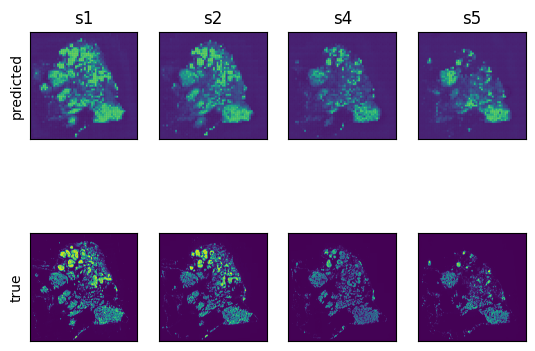

In [90]:
mushroom.display_predicted_pixels(channel='Pan-Cytokeratin')

In [246]:
mushroom.cluster_sections()

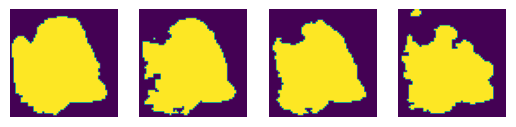

In [247]:
mushroom.clusterer.display_section_masks()

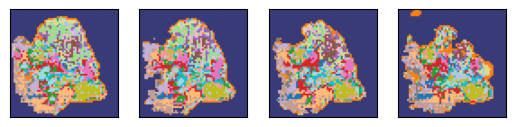

In [249]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

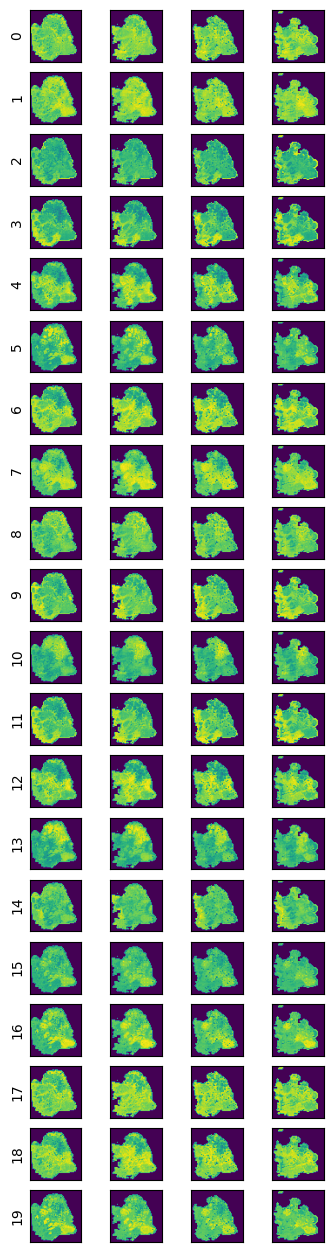

In [250]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

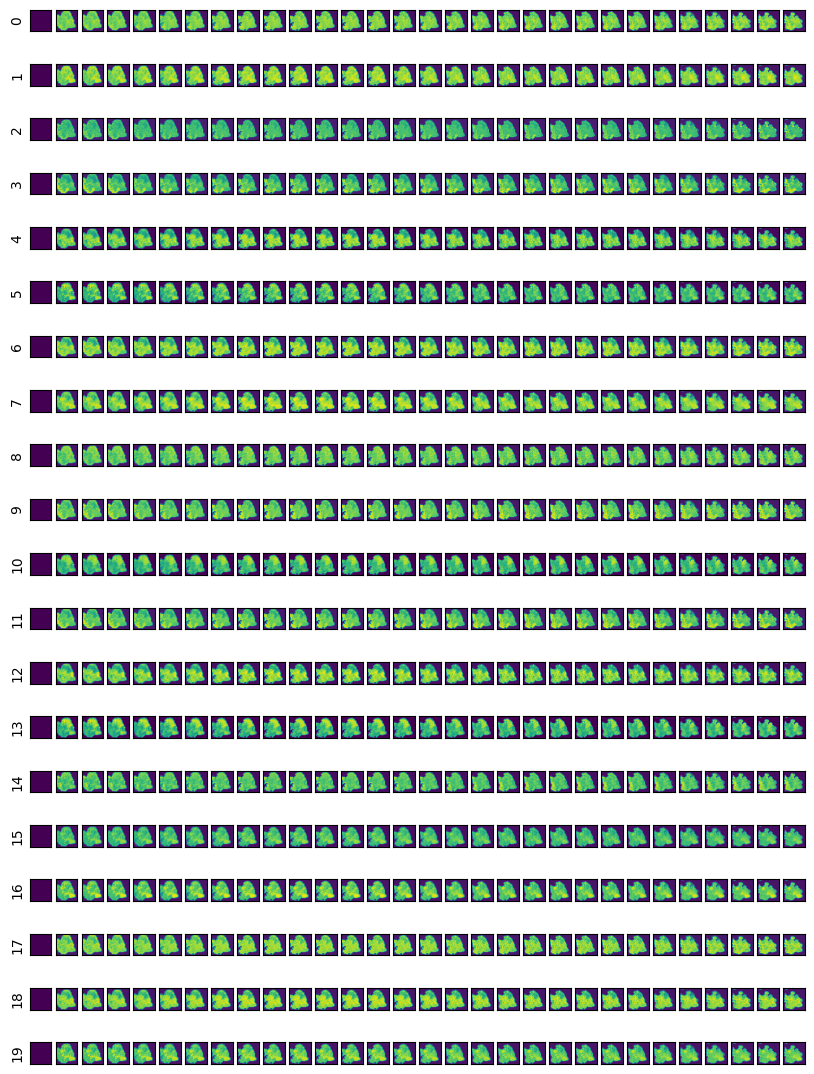

In [251]:
mushroom.clusterer.display_distances(mushroom.dists_volume, figsize=(10, 14))

In [255]:
mushroom.cluster_sections(recluster=False)

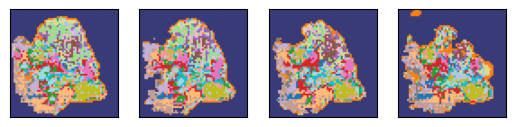

In [256]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

In [268]:
mushroom.save_config(os.path.join(out_dir, 'config.yaml'))

In [269]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [8]:
loaded_mushroom = Mushroom.from_config(os.path.join(out_dir, 'config.yaml'))

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset


In [289]:
loaded_mushroom.embed_sections()

In [290]:
loaded_mushroom.cluster_sections(recluster=False)

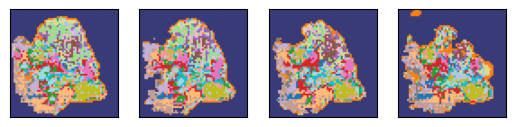

In [292]:
loaded_mushroom.clusterer.display_cluster_ids(loaded_mushroom.cluster_ids)

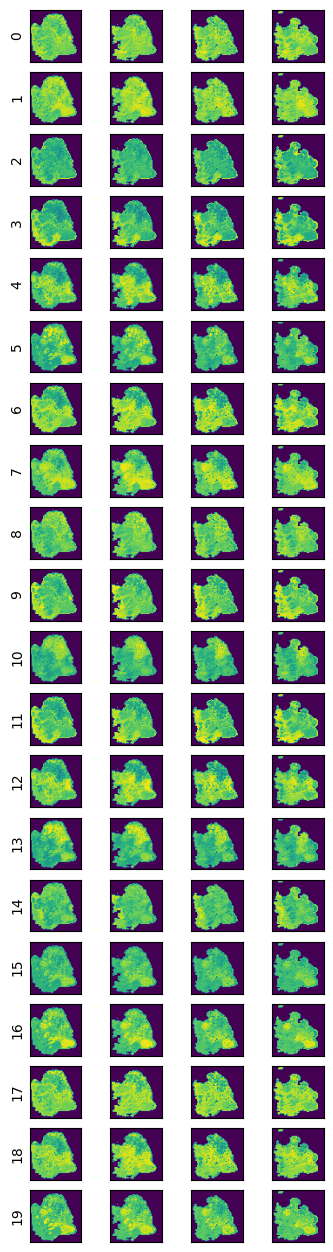

In [293]:
loaded_mushroom.clusterer.display_distances(loaded_mushroom.dists, figsize=(4, 16))

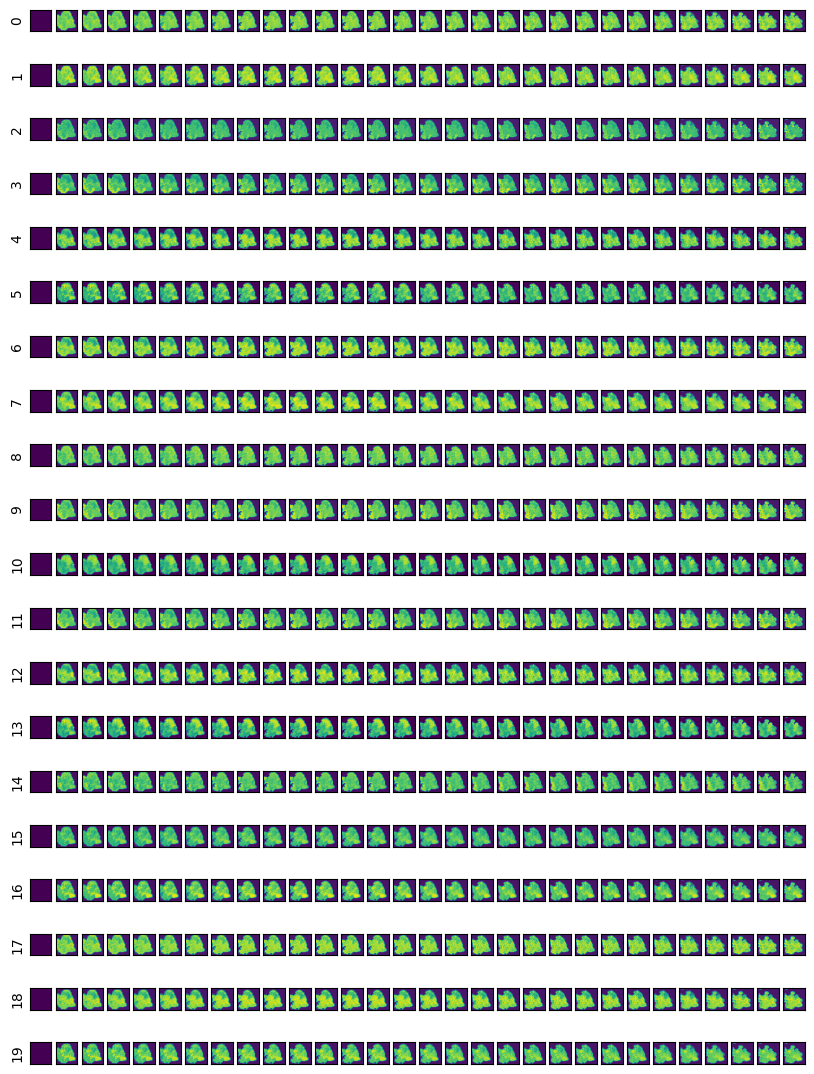

In [294]:
loaded_mushroom.clusterer.display_distances(loaded_mushroom.dists_volume, figsize=(10, 14))

## visium

In [81]:
out_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium'
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [85]:
mushroom_config = {
    'dtype': 'visium',
    'sections': section_config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
#         'patch_size': 
        'triplet_scaler': 1.,
        'recon_scaler': 1.
    },
    'learner_kwargs': {
        'scale': .1,
        'num_workers': 4,
        'pct_expression': .02,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10,
        'lr': 1e-4,
        'log_every': 1,
        'save_every': 100,
        'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True
    }
}

In [158]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11608 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset


torch.Size([60, 60, 1024])
torch.Size([60, 60, 1024])
torch.Size([60, 60, 1024])
torch.Size([60, 60, 919])


INFO:root:no background channel detected, defaulting to mean of all channels


In [163]:
d = mushroom.learner.train_ds[0]
d.keys()

torch.Size([8, 8, 1024])
torch.Size([8, 8, 34])
torch.Size([8, 8, 1024])
torch.Size([8, 8, 37])
torch.Size([8, 8, 1024])
torch.Size([8, 8, 127])


dict_keys(['anchor_idx', 'pos_idx', 'neg_idx', 'anchor_img', 'pos_img', 'neg_img'])

In [164]:
d['anchor_img'].shape

torch.Size([11608, 8, 8])

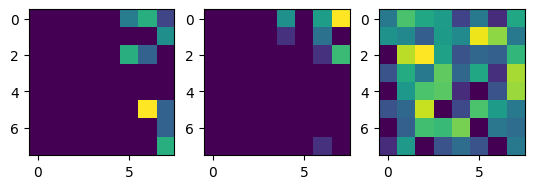

In [165]:
fig, axs = plt.subplots(ncols=3)
idx = mushroom.learner.channels.index('EPCAM')
axs[0].imshow(d['anchor_img'][idx])
axs[1].imshow(d['pos_img'][idx])
axs[2].imshow(d['neg_img'][idx])

In [166]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(1.2333, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8124, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium/chkpts/0iter.pt
INFO:root:iteration 1: {'overall_loss': tensor(1.3147, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8283, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 2: {'overall_loss': tensor(1.1242, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7840, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 3: {'overall_loss': tensor(1.0845, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7554, device='cuda:0', grad_fn=<DivBac

In [167]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

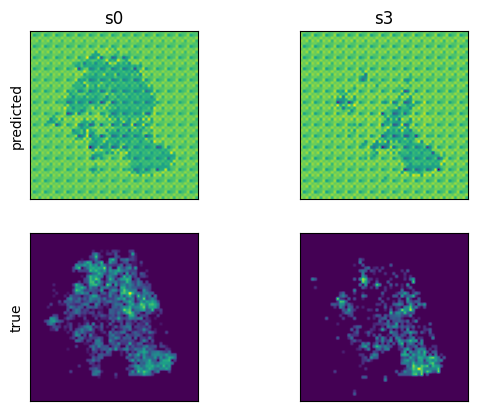

In [168]:
mushroom.display_predicted_pixels(channel='EPCAM')

In [170]:
mushroom.cluster_sections()

INFO:root:no background channel detected, defaulting to mean of all channels


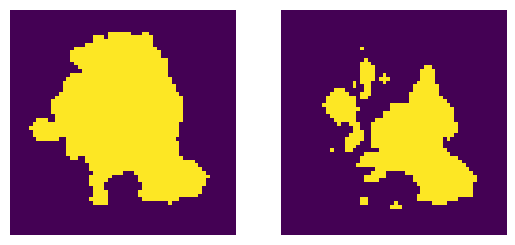

In [171]:
mushroom.clusterer.display_section_masks()

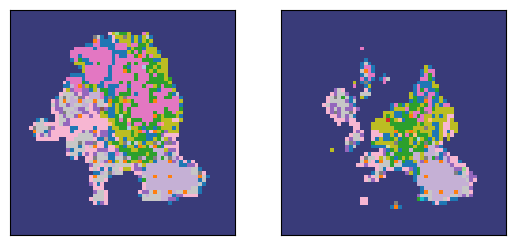

In [172]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

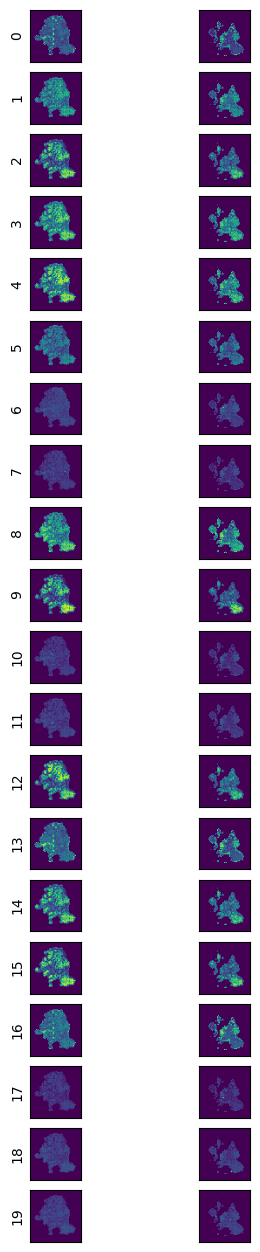

In [173]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

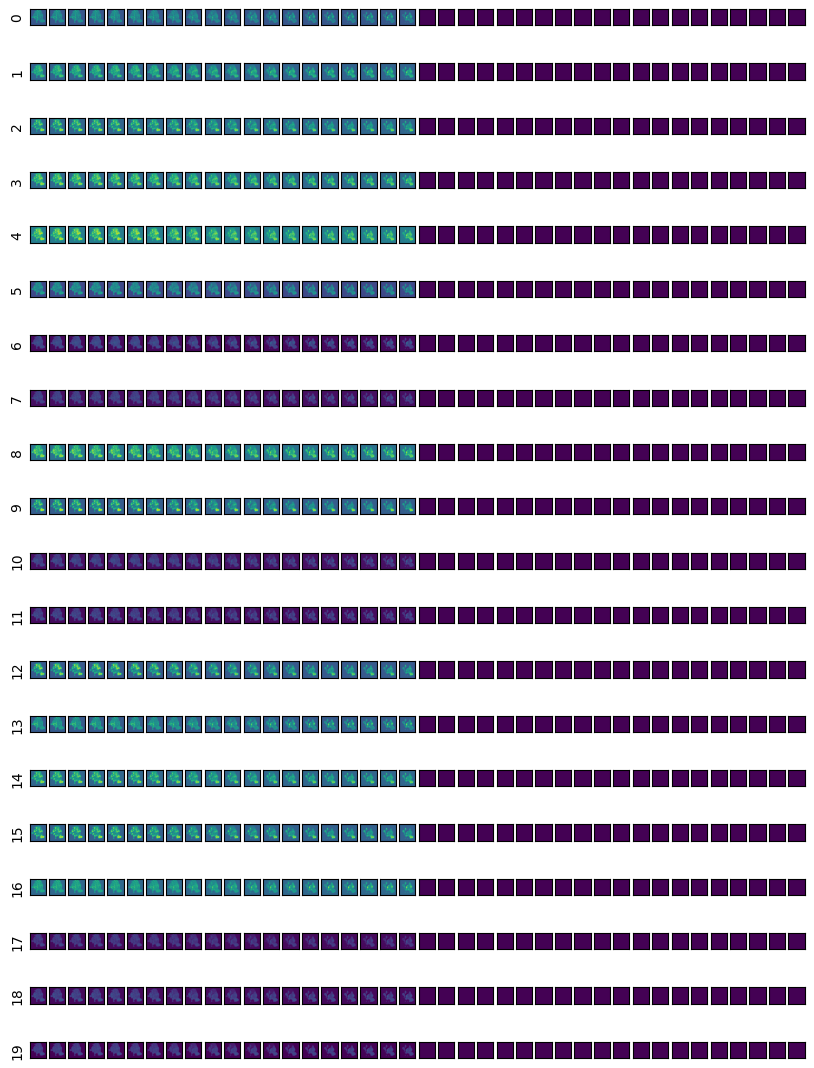

In [174]:
mushroom.clusterer.display_distances(mushroom.dists_volume, figsize=(10, 14))

In [175]:
mushroom.save_config(os.path.join(out_dir, 'config.yaml'))

In [176]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))